In [31]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
from torchinfo import summary

import numpy as np

from misc.datasets_ae import AutoencoderDataset, MNIST_w_imagesums
from misc.autoencoder import Autoencoder, MNIST_ConvEncoder, MNIST_ConvDecoder
from torchinfo import summary
from PIL import Image, ImageFilter

import random

In [8]:
DEVICE = 'cuda:0'

SEED = 0

torch.backends.cudnn.enabled = False
torch.manual_seed(SEED)
np.random.seed(SEED)

# Data

In [108]:
class IndexDataset(torch.utils.data.Dataset):
    """
    Simple wrapper to get the index of each element in the original dataset
    """
    
    def __init__(self, dataset : torch.utils.data.Dataset):
        """
        Initialization.
        
        Parameters
        ----------
        dataset
            The dataset which to wrap.
        """
        
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        outs = self.dataset[index]
        return index, *outs 

    
class GaussianBlur(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            sigma = random.random() * 1.9 + 0.1
            return img.filter(ImageFilter.GaussianBlur(sigma))
        else:
            return img

    
class BarlowTwinsDataset(torch.utils.data.Dataset):
    """
    Simple wrapper to get the index of each element in the original dataset
    """
    
    def __init__(self, dataset : torch.utils.data.Dataset, transforms):
        """
        Initialization.
        
        Parameters
        ----------
        dataset
            The dataset which to wrap.
        """
        
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        x, y = self.dataset[index]
        x_1 = self.transforms(x)
        x_2 = self.transforms(x)
        
        return x, x_1, x_2

In [109]:
batch_size_train = 512
batch_size_test  = 1024

barlow_twins_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomResizedCrop(28, interpolation=Image.BICUBIC),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
#     torchvision.transforms.RandomApply(
#         [transforms.ColorJitter(brightness=0.4, contrast=0.4,
#                                 saturation=0.2, hue=0.1)],
#         p=0.8
#     ),
#     torchvision.transforms.RandomGrayscale(p=0.2),
    GaussianBlur(p=1.0),
#     torchvision.transforms.RandomSolarize(p=0.2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = torchvision.datasets.MNIST(root="./files/", download=True, transform=test_transforms)
# test_ds = torchvision.datasets.MNIST(root="./files/", download=True, transform=test_transforms, train=False)

aug_ratio = 0.1
train_ds = MNIST_w_imagesums(train_ds, aug_ratio=aug_ratio)

train_ds = BarlowTwinsDataset(train_ds, barlow_twins_transforms)
# test_ds = BarlowTwinsDataset(test_ds, barlow_twins_transforms)

split_1_ds, split_2_ds = torch.utils.data.random_split(train_ds, [len(train_ds) // 2]*2)
split_1_ds = IndexDataset(split_1_ds)
split_2_ds = IndexDataset(split_2_ds)

split1_loader = torch.utils.data.DataLoader(split_1_ds, 
                                            batch_size=batch_size_train, 
                                            shuffle=True, 
                                            num_workers=8,
                                            pin_memory=True)
split2_loader = torch.utils.data.DataLoader(split_2_ds, 
                                            batch_size=batch_size_train, 
                                            shuffle=True, 
                                            num_workers=8,
                                            pin_memory=True)

# test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size_test, shuffle=False)

/tmp/ipykernel_38109/712628991.py:6: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  torchvision.transforms.RandomResizedCrop(28, interpolation=Image.BICUBIC),


# Training model

In [190]:
def off_diagonal(x):
    # return a flattened view of the off-diagonal elements of a square matrix
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:]

def barlow_twins_loss(z_1, z_2, l):
    c = z_1.T @ z_2
    c.div_(z_1.shape[0])

    on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
    off_diag = off_diagonal(c).flatten().pow_(2).sum()
    loss = on_diag + l * off_diag
    return loss

def sample_correlation(z_1, z_2):
    c = z_1 @ z_2.T
    c.div_(z_1.shape[1])
    
    n = c.shape[0]
    
    self_correlaton = torch.diagonal(c) # Nx1
    cross_correlation = off_diagonal(c).pow_(2).reshape(n, n-1).sum(dim=-1) # Nx1
    
    return self_correlaton.cpu().numpy(), cross_correlation.cpu().numpy()

def feature_correlation(z_1, z_2):
    c = z_1.T @ z_2
    c.div_(z_1.shape[0])
    
    n = c.shape[0]
    
    self_correlaton = torch.diagonal(c) # Dx1
    cross_correlation = off_diagonal(c).pow_(2).reshape(n, n-1).sum(dim=-1) # Dx1
    
    return self_correlaton.cpu().numpy(), cross_correlation.cpu().numpy()

def log_correlation(sample_idx, z_1, z_2, sample_corr_list):
    sample_selfcorr, sample_crosscorr = sample_correlation(z_1, z_2)
    sample_corr = np.hstack([sample_idx.numpy().reshape(-1, 1), 
                             sample_selfcorr.reshape(-1, 1),
                             sample_crosscorr.reshape(-1, 1)
                            ])
    sample_corr_list.append(sample_corr)
    return sample_corr_list
    
def train(model, epoch, train_loader, loss_fn, log_loader=None, log_step_rel=1.0):
    model.train()
    sample_corr = []
    train_losses = []

    if log_loader is None:
        log_loader = train_loader
        log_step = None
    else:
        log_step = int(log_step_rel * len(train_loader))

    for step, (sample_idx, x, x_1, x_2) in enumerate(train_loader):
        optimizer.zero_grad()
        
        x_1 = x_1.to(DEVICE)
        x_2 = x_2.to(DEVICE)

        y_1 = model(x_1)
        y_2 = model(x_2)
        
        # could be batchnorm
        z_1 = (y_1 - y_1.mean(dim=0)) / y_1.std(dim=0)
        z_2 = (y_2 - y_2.mean(dim=0)) / y_2.std(dim=0)
        
        loss = loss_fn(z_1, z_2)
        loss.backward()
        optimizer.step()

        ## sample_scores calculation
        
        with torch.no_grad():
            if log_step is None:
                model.eval()
                log_correlation(sample_idx, z_1.detach(), z_2.detach(), sample_corr)
                model.train()
            elif step % log_step == 0:
                sc = test(model, log_loader)
                sample_corr.append(sc)
                model.train()

        train_losses.append(loss.item())
    
    sample_corr = np.vstack(sample_corr)
    
    return train_losses, sample_corr

In [191]:
def test(model, test_loader):
    model.eval()
    sample_corr = []
    
    with torch.no_grad():
        for sample_idx, x, x_1, x_2 in test_loader:
            x_1 = x_1.to(DEVICE)
            x_2 = x_2.to(DEVICE)

            y_1 = model(x_1)
            y_2 = model(x_2)

            # could be batchnorm
            z_1 = (y_1 - y_1.mean(dim=0)) / y_1.std(dim=0)
            z_2 = (y_2 - y_2.mean(dim=0)) / y_2.std(dim=0)

            log_correlation(sample_idx, z_1.detach(), z_2.detach(), sample_corr)

    sample_corr = np.vstack(sample_corr)
    
    return sample_corr

# Network

In [192]:
class BT_CNN(nn.Module):
    def __init__(self, in_channels=3, latent_dim=512):
        super(BT_CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        self.projector = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1600, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            
            nn.Linear(1024, latent_dim)
        )

    def forward(self, x):

        feats = self.features(x)
        logits = self.projector(feats)
        
        return logits

# SSFT

### First Split Training

In [193]:
learning_rate = 1e-3
LAMBDA = 0.0051
LATENT_DIM = 500

loss_fn = lambda x, y: barlow_twins_loss(x, y, l=LAMBDA)
n_epochs = 500

model = BT_CNN(in_channels=1, latent_dim=LATENT_DIM).to(DEVICE)

# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

In [194]:
# t = split1_loader
# split1_loader = split2_loader
# split2_loader = t
# curr_split_ds = split_2_ds
# print('Swapped split_1 and split_2')

In [ ]:
from tqdm.auto import tqdm


sample_corr_by_epoch = []
train_losses = []
train_accs = []

for epoch in tqdm(range(1, n_epochs + 1)):
    losses, sample_corr = train(model, epoch, split1_loader, loss_fn)
    
    train_losses.append(losses)
    sample_corr_by_epoch.append(sample_corr)
    
    print(f'Epoch {epoch} loss: {np.mean(losses)}')

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1 loss: 271.570581981114
Epoch 2 loss: 189.94429479326521
Epoch 3 loss: 172.08513968331474
Epoch 4 loss: 161.1141300201416
Epoch 5 loss: 150.3536935533796
Epoch 6 loss: 142.26718248639787
Epoch 7 loss: 135.6582623890468
Epoch 8 loss: 132.42446081978935
Epoch 9 loss: 127.98582376752582
Epoch 10 loss: 124.51287637438092
Epoch 11 loss: 122.24729101998466
Epoch 12 loss: 119.601213318961
Epoch 13 loss: 118.02094323294503
Epoch 14 loss: 116.55579444340297
Epoch 15 loss: 114.14201899937221
Epoch 16 loss: 113.35932636260986
Epoch 17 loss: 111.35279955182757
Epoch 18 loss: 109.86990424564907
Epoch 19 loss: 108.94322218213763
Epoch 20 loss: 107.82726233346122
Epoch 21 loss: 106.76715183258057
Epoch 22 loss: 105.56963934217181
Epoch 23 loss: 104.08759798322406
Epoch 24 loss: 104.73605932508197
Epoch 25 loss: 103.93339960915702
Epoch 26 loss: 102.77799197605678
Epoch 27 loss: 102.03813879830497
Epoch 28 loss: 101.65911974225726
Epoch 29 loss: 101.58953176225934
Epoch 30 loss: 100.75189685821

In [196]:
step_losses = np.concatenate(train_losses)

epoch_losses = np.mean(train_losses, axis=1)

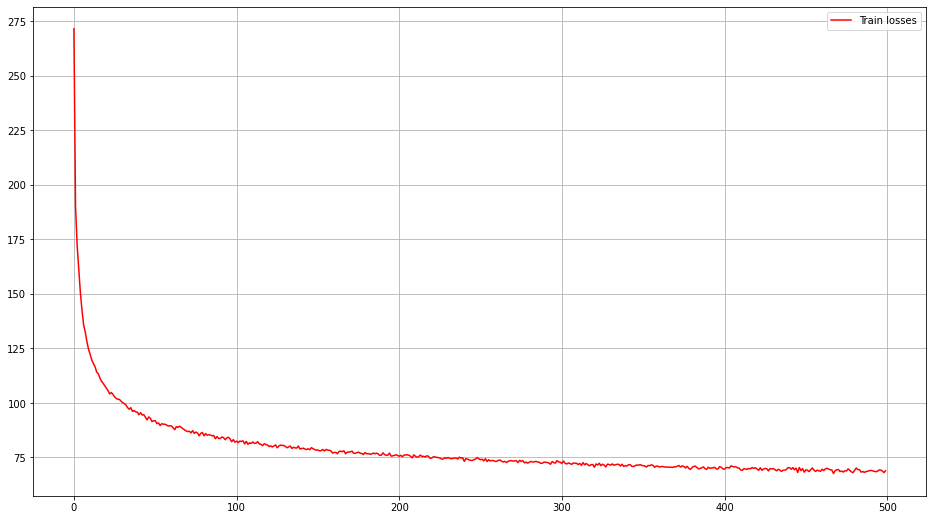

In [197]:
plt.figure(figsize=(16, 9))
plt.plot(epoch_losses, color='red', label='Train losses')
# plt.axhline(1)
plt.grid()
plt.legend()

In [269]:
sample_corr_by_epoch = np.array(sample_corr_by_epoch)

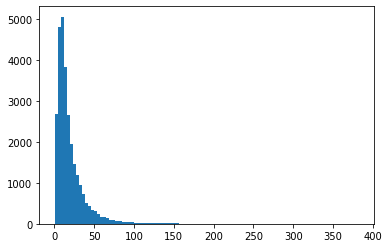

In [214]:
# plt.hist(sample_corr_by_epoch[0][:, 2])
plt.hist(sample_corr_by_epoch[-1][:, 2], bins=100)
plt.show()

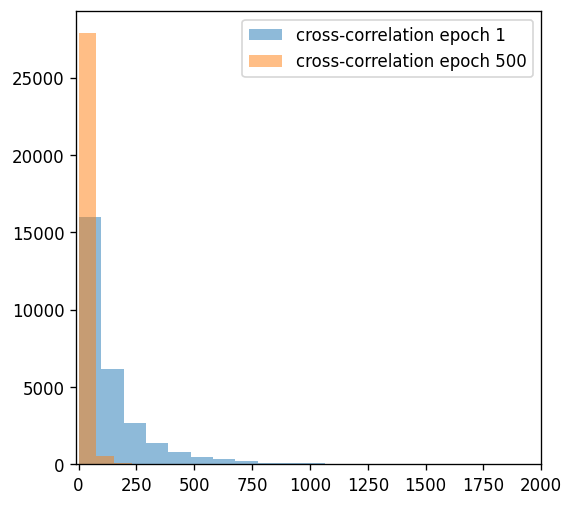

In [357]:
plt.figure(figsize=(5, 5), dpi=120)
plt.hist(sample_corr_by_epoch[0][:, 2], bins=70, alpha=0.5, label='cross-correlation epoch 1')
plt.hist(sample_corr_by_epoch[-1][:, 2], bins=5, alpha=0.5, label='cross-correlation epoch 500')
# plt.ylim(0, 2000)
plt.legend()
plt.xlim(-10, 2000)
plt.show()

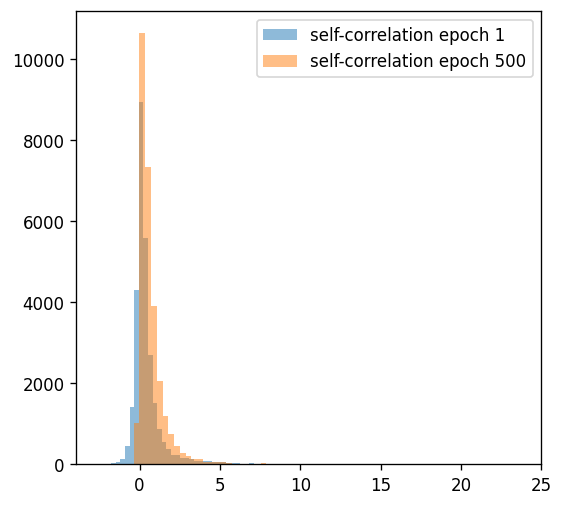

In [360]:
plt.figure(figsize=(5, 5), dpi=120)
plt.hist(sample_corr_by_epoch[0][:, 1], bins=70, alpha=0.5, label='self-correlation epoch 1')
plt.hist(sample_corr_by_epoch[-1][:, 1], bins=70, alpha=0.5, label='self-correlation epoch 500')
# plt.ylim(0, 2000)
plt.legend()
# plt.xlim(-10, 2000)
plt.show()

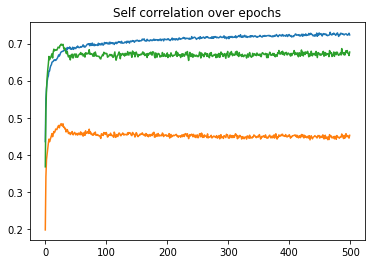

In [261]:
a = np.array(sample_corr_by_epoch)
mean_corr_by_epoch = np.mean(a[:, :, 1], axis=1)
median_corr_by_epoch = np.median(a[:, :, 1], axis=1)
q_corr_by_epoch = np.quantile(a[:, :, 1], 0.65, axis=1)
plt.plot(mean_corr_by_epoch)
plt.plot(median_corr_by_epoch)
plt.plot(q_corr_by_epoch)
plt.title('Self correlation over epochs')
plt.show()

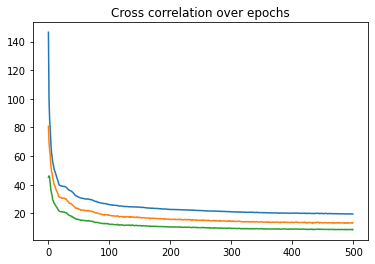

In [266]:
a = np.array(sample_corr_by_epoch)
mean_corr_by_epoch = np.mean(a[:, :, 2], axis=1)
median_corr_by_epoch = np.median(a[:, :, 2], axis=1)
q_corr_by_epoch = np.quantile(a[:, :, 2], 0.3, axis=1)
plt.plot(mean_corr_by_epoch)
plt.plot(median_corr_by_epoch)
plt.plot(q_corr_by_epoch)
plt.title('Cross correlation over epochs')
plt.show()

In [ ]:
# sample learnt if selfcorr > 0.45
# sample learnt if crosscorr < 40

### Learning time

In [267]:
def learning_time_from_selfcorr(sample_scores_by_epoch, thr=0.45):
    learning_times = {}
    learning_times_step = {}
    
    # Iterate over epochs
    for epoch, scores in tqdm(enumerate(sample_scores_by_epoch), total=len(sample_scores_by_epoch)):
        # Iterate over samples in the epoch
        for step, (sample_idx, score) in enumerate(scores):
            sample_idx = int(sample_idx)
            
            # reset not yet learnt or forgotten samples 
            if sample_idx not in learning_times or score < thr:
                learning_times[sample_idx] = -1
                learning_times_step[sample_idx] = -1
    
            if score > thr and learning_times[sample_idx] == -1:
                learning_times[sample_idx] = epoch
                learning_times_step[sample_idx] = epoch*len(scores) + step

    return learning_times, learning_times_step

def learning_time_from_crosscor(sample_scores_by_epoch, thr=40):
    learning_times = {}
    learning_times_step = {}
    
    # Iterate over epochs
    for epoch, scores in tqdm(enumerate(sample_scores_by_epoch), total=len(sample_scores_by_epoch)):
        # Iterate over samples in the epoch
        for step, (sample_idx, score) in enumerate(scores):
            sample_idx = int(sample_idx)
            
            # reset not yet learnt or forgotten samples 
            if sample_idx not in learning_times or score > thr:
                learning_times[sample_idx] = -1
                learning_times_step[sample_idx] = -1
    
            if score < thr and learning_times[sample_idx] == -1:
                learning_times[sample_idx] = epoch
                learning_times_step[sample_idx] = epoch*len(scores) + step

    return learning_times, learning_times_step

In [270]:
selfcorr_learning_times, selfcorr_learning_times_step = \
    learning_time_from_selfcorr(sample_corr_by_epoch[:, :, [0, 1]], thr=0.45)
crosscorr_learning_times, crosscorr_learning_times_step = \
    learning_time_from_crosscor(sample_corr_by_epoch[:, :, [0, 2]], thr=40)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [279]:
split_1_metrics_df = pd.DataFrame(
    [(idx, selfcorr_learning_times_step[idx], crosscorr_learning_times_step[idx]) for idx in selfcorr_learning_times_step.keys()],
    columns = ['sample_idx', 'selfcorr_learning_time', 'crosscorr_learning_time']
)

<AxesSubplot:>

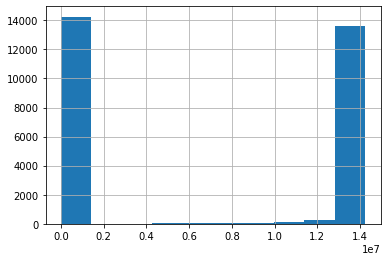

In [274]:
split_1_metrics_df.selfcorr_learning_time.hist(bins=10)

# Second Split training

In [215]:
from tqdm.auto import tqdm

n_epochs = 500

split_1_sample_corr_by_epoch = []
split_1_train_losses = []

for epoch in tqdm(range(1, n_epochs + 1)):
    losses, sample_corr = train(model, epoch, split2_loader, loss_fn, 
                                                      log_loader=split1_loader, log_step_rel=0.25)

    split_1_train_losses.append(losses)
    split_1_sample_corr_by_epoch.append(sample_corr)

  0%|          | 0/500 [00:00<?, ?it/s]

In [216]:
step_losses = np.concatenate(split_1_train_losses)

epoch_losses = np.mean(split_1_train_losses, axis=1)

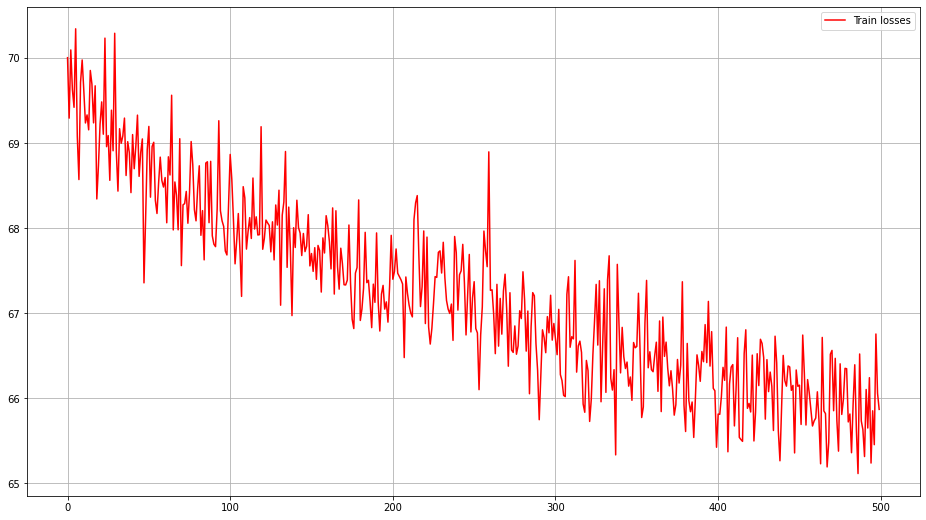

In [217]:
plt.figure(figsize=(16, 9))
plt.plot(epoch_losses, color='red', label='Train losses')
# plt.axhline(1)
plt.grid()
plt.legend()

In [275]:
split_1_sample_corr_by_epoch = np.array(split_1_sample_corr_by_epoch)

### Forgetting Time

In [276]:
def forgetting_time_from_selfcorr(split_1_sample_scores_by_epoch, dataset, thr=0.45):
    forgetting_times = {}
    forgetting_times_step = {}
    
    # Iterate over epochs
    for epoch, scores in tqdm(enumerate(split_1_sample_scores_by_epoch), total=len(split_1_sample_scores_by_epoch)):
        # Iterate over samples in the epoch

        num_logs_per_epoch = len(scores) // len(dataset) - 1
        steps_per_log = len(dataset) // num_logs_per_epoch

        for step, (sample_idx, score) in enumerate(scores):
            sample_idx = int(sample_idx)
            log_step = step // len(dataset)

            # reset not yet forgotten samples 
            if sample_idx not in forgetting_times or score > thr:
                forgetting_times[sample_idx] = -1
                forgetting_times_step[sample_idx] = -1
    
            if score < thr and forgetting_times[sample_idx] == -1:
                forgetting_times[sample_idx] = epoch
                forgetting_times_step[sample_idx] = (epoch*num_logs_per_epoch + log_step) * steps_per_log
    return forgetting_times, forgetting_times_step

def forgetting_time_from_crosscorr(split_1_sample_scores_by_epoch, dataset, thr=40):
    forgetting_times = {}
    forgetting_times_step = {}
    
    # Iterate over epochs
    for epoch, scores in tqdm(enumerate(split_1_sample_scores_by_epoch), total=len(split_1_sample_scores_by_epoch)):
        # Iterate over samples in the epoch

        num_logs_per_epoch = len(scores) // len(dataset) - 1
        steps_per_log = len(dataset) // num_logs_per_epoch

        for step, (sample_idx, score) in enumerate(scores):
            sample_idx = int(sample_idx)
            log_step = step // len(dataset)

            # reset not yet forgotten samples 
            if sample_idx not in forgetting_times or score < thr:
                forgetting_times[sample_idx] = -1
                forgetting_times_step[sample_idx] = -1
    
            if score > thr and forgetting_times[sample_idx] == -1:
                forgetting_times[sample_idx] = epoch
                forgetting_times_step[sample_idx] = (epoch*num_logs_per_epoch + log_step) * steps_per_log
    return forgetting_times, forgetting_times_step

In [281]:
forgetting_times_selfcorr, fogetting_times_selfcorr_steps = \
    forgetting_time_from_selfcorr(split_1_sample_corr_by_epoch[:, :, [0, 1]], split_1_ds, thr=0.45)
forgetting_times_croscorr, fogetting_times_crosscorr_steps = \
    forgetting_time_from_crosscorr(split_1_sample_corr_by_epoch[:, :, [0, 2]], split_1_ds, thr=40)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [282]:
split_1_forgetting_time_df = pd.DataFrame(
    [(idx, fogetting_times_selfcorr_steps[idx], fogetting_times_crosscorr_steps[idx]) for idx in fogetting_times_selfcorr_steps.keys()],
    columns = ['sample_idx', 'selfcorr_forgetting_time', 'crosscorr_forgetting_time']
)

# Analysis

In [327]:
to_comp = 'selfcorr' # scores/preds
ft_metric = f'{to_comp}_forgetting_time'
lt_metric = f'{to_comp}_learning_time'

curr_split_ds = split_1_ds

metrics_df = pd.merge(split_1_metrics_df, split_1_forgetting_time_df, on='sample_idx')
never_forgotten_thr = metrics_df[ft_metric].max() + 5000
metrics_df.loc[metrics_df[ft_metric] == -1, ft_metric] = never_forgotten_thr + 5000

In [328]:
shuffled_idx_2_original_idx = {i : x for i, x in enumerate(curr_split_ds.dataset.indices)}
metrics_df['original_sample_idx'] = metrics_df.sample_idx.apply(lambda x: shuffled_idx_2_original_idx[x])

In [329]:
# corrupted_indices = curr_split_ds.dataset.dataset.corrupted_indices
corrupted_indices = list(curr_split_ds.dataset.dataset.dataset.dd_idxs_aug.keys())
metrics_df['is_mislabeled'] = False
metrics_df.loc[metrics_df.original_sample_idx.isin(corrupted_indices), 'is_mislabeled'] = True

In [330]:
# metrics_df.to_csv('./cnn_225k_mnist_sup_metrics_split_2.csv', index=False)

In [331]:
learning_time = metrics_df[lt_metric].values
forgetting_time = metrics_df[ft_metric].values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


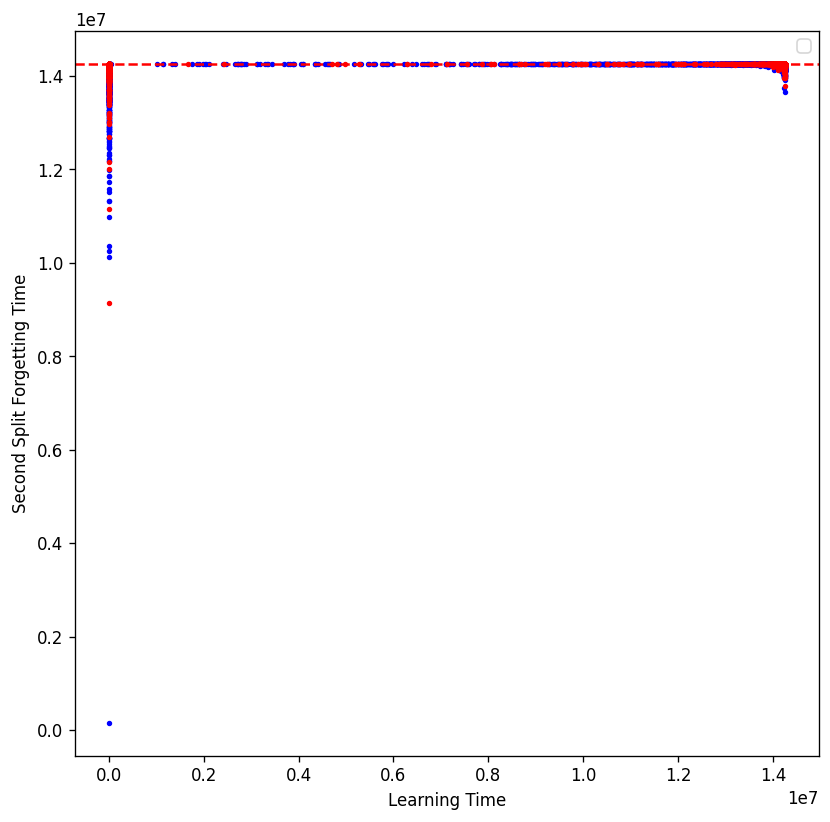

In [332]:
plt.figure(figsize=(8, 8), dpi=120)
plt.scatter(learning_time[metrics_df[~metrics_df.is_mislabeled].index], forgetting_time[metrics_df[~metrics_df.is_mislabeled].index],
            s=5, c='blue')
plt.scatter(learning_time[metrics_df[metrics_df.is_mislabeled].index], forgetting_time[metrics_df[metrics_df.is_mislabeled].index],
            s=5, c='r')
plt.axhline(y=never_forgotten_thr, linestyle='dashed', c='red')
plt.xlabel('Learning Time')
plt.ylabel('Second Split Forgetting Time')
plt.legend()
plt.show()


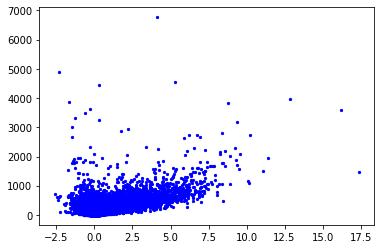

In [298]:
plt.scatter(sample_corr_by_epoch[0, :, 1], sample_corr_by_epoch[0, :, 2],
            s=5, c='blue')

In [325]:
df = pd.DataFrame(split_1_sample_corr_by_epoch[-1], columns=['sample_idx', 'selfcorr', 'crosscorr'])
df['sample_idx'] = df.sample_idx.apply(lambda x: int(x))

df['original_sample_idx'] = df.sample_idx.apply(lambda x: shuffled_idx_2_original_idx[x])
df['is_mislabeled'] = False
df.loc[df.original_sample_idx.isin(corrupted_indices), 'is_mislabeled'] = True

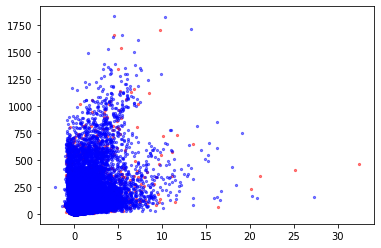

In [339]:
plt.scatter(df[df.is_mislabeled].selfcorr, df[df.is_mislabeled].crosscorr,
            s=5, c='red', alpha=0.5)

plt.scatter(df[~df.is_mislabeled].selfcorr, df[~df.is_mislabeled].crosscorr,
            s=5, c='blue', alpha=0.5)

# plt.scatter(learning_time[metrics_df[metrics_df.is_mislabeled].index], forgetting_time[metrics_df[metrics_df.is_mislabeled].index],
#             s=5, c='r')

# sample_corr_by_epoch[-1, :, 1]

In [148]:
mislabeled_subset = metrics_df[(metrics_df[lt_metric] > 1.75e6) & (metrics_df[ft_metric] < 0.5e6)].sample_idx.values
ambigious_subset = metrics_df[(metrics_df[lt_metric] < 0.5e6) & (metrics_df[ft_metric] < 0.5e6)].sample_idx.values
typical_subset = metrics_df[(metrics_df[lt_metric] < 0.5e6) & (metrics_df[ft_metric] > 2.5e6)].sample_idx.values
atypical_subset = metrics_df[(metrics_df[lt_metric] > 2e6) & (metrics_df[ft_metric] > 2.5e6)].sample_idx.values

# split1_ds[2]

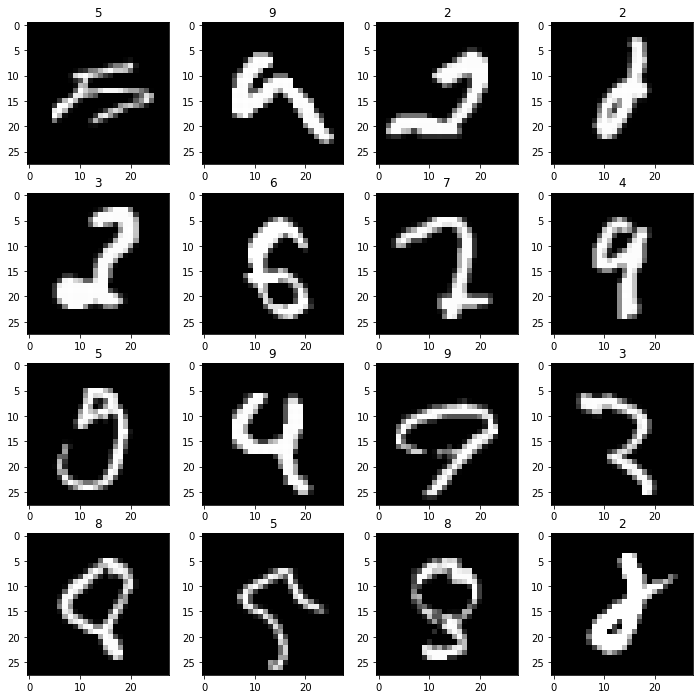

In [149]:
subset = ambigious_subset
# subset = [3845, 55894]

fig, ax = plt.subplots(4, 4, figsize=(12, 12))
ax = ax.ravel()

for i in range(len(subset)):
    if i >= 16:
        break
    
    idx = subset[i]
    
    unnormalize = lambda x: x*0.3081 + 0.1307
    
    _, img, label = curr_split_ds[idx]
    np_img = (unnormalize(img.squeeze().numpy())*255).astype(int)

    ax[i].imshow(np_img, cmap='gray')
    ax[i].set_title(label)

# Classification

In [176]:
m1 = pd.read_csv('./cnn_225k_mnist_sup_metrics.csv')
m2 = pd.read_csv('./cnn_225k_mnist_sup_metrics_split_2.csv')

In [177]:
m = pd.concat([m1, m2]).reset_index()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


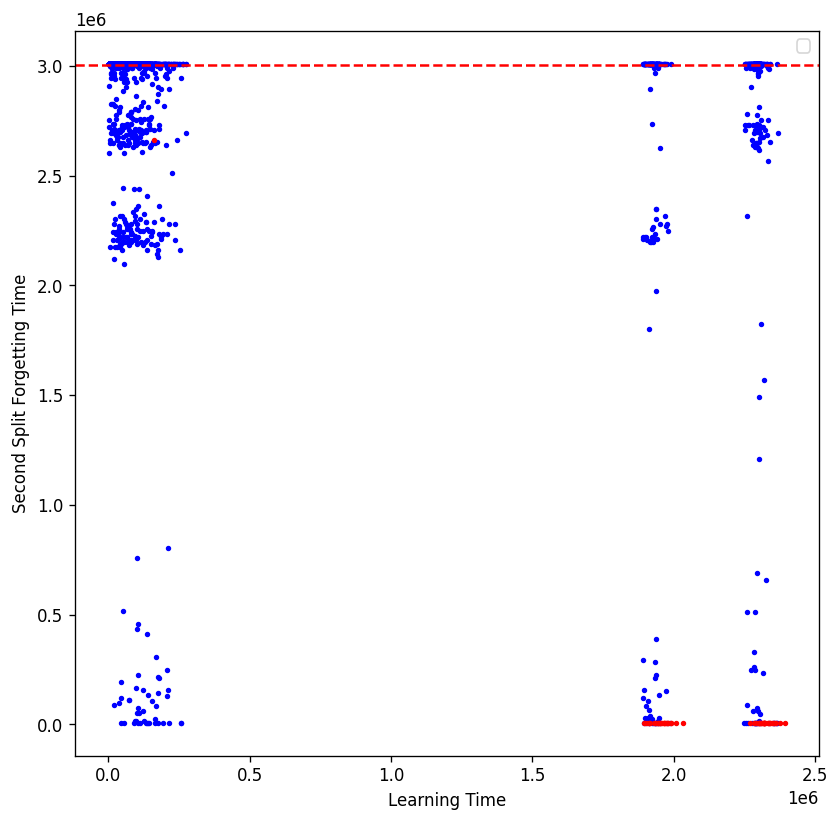

In [178]:
learning_time = m[lt_metric]
forgetting_time = m[ft_metric]
df = m

plt.figure(figsize=(8, 8), dpi=120)
plt.scatter(learning_time[df[~df.is_mislabeled].index], forgetting_time[df[~df.is_mislabeled].index],
            s=5, c='blue')
plt.scatter(learning_time[df[df.is_mislabeled].index], forgetting_time[df[df.is_mislabeled].index],
            s=5, c='r')
plt.axhline(y=never_forgotten_thr, linestyle='dashed', c='red')
plt.xlabel('Learning Time')
plt.ylabel('Second Split Forgetting Time')
plt.legend()
plt.show()


In [182]:
df['prediction'] = 'none'
df.loc[(df[lt_metric] > 1.25e6) & (df[ft_metric] < 1.5e6), 'prediction'] = 'mislabeled'
df.loc[(df[lt_metric] < 1.25e6) & (df[ft_metric] < 1.5e6), 'prediction'] = 'ambigious'
df.loc[(df[lt_metric] < 1.25e6) & (df[ft_metric] > 1.5e6), 'prediction'] = 'typical'
df.loc[(df[lt_metric] > 1.25e6) & (df[ft_metric] > 1.5e6), 'prediction'] = 'atypical'

In [202]:
df[df.prediction == 'mislabeled'].is_mislabeled.value_counts()

False    70
True     59
Name: is_mislabeled, dtype: int64

In [194]:
df

,index,sample_idx,scores_learning_time,preds_learning_time,scores_forgetting_time,preds_forgetting_time,original_sample_idx,is_mislabeled,prediction
0,0,26028,59367,59367,3010000,-1,39689,False,typical
1,1,6792,34998,34998,3010000,-1,28623,False,typical
2,2,2966,32257,32257,3010000,-1,58165,False,typical
3,3,27994,36990,3,3010000,-1,15180,False,typical
4,4,13494,47702,47702,3010000,-1,29298,False,typical
...,...,...,...,...,...,...,...,...,...
59995,29995,21594,29995,-1,3010000,0,9761,False,typical
59996,29996,14195,29996,-1,3010000,0,41028,False,typical
59997,29997,14053,29997,-1,3010000,0,3277,False,typical
59998,29998,22408,29998,-1,3010000,0,51903,False,typical


In [192]:
df.to_csv('./cnn225k_mnist_sup_both_splits.csv', index=False)

# TODO

1. Syntetic label flips
2. Сложить картинки и получить зашумленные картинки
3. Посмотреть корреляции с метриками
4. Уменьшить LR –> больше шагов/деталей
5. Подумать над другими метриками
6. Далее посмотреть на корреляцию с другими методами выделения аутлаеров